In [1]:
%pylab inline
from pylab import *
import cv2
from skimage.transform import resize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_im(filepath):
    if filepath[len(filepath)-3:] == 'tif':
        return imread(filepath)/65536.0
    return imread(filepath)/255.0

im = read_im('../data/cathedral.jpg')

print("Size of the image is %d x %d" % (im.shape[0], im.shape[1]))
print("Size of the individual plates is %d x %d" % (im.shape[0] // 3, im.shape[1]))


Size of the image is 1024 x 390
Size of the individual plates is 341 x 390


In [3]:
def translate(im, ty, tx):
    """
    Helper function that translates an image.
    """
    height, width = im.shape[:2]
    mat = translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (width, height))

In [4]:
def adjust_and_composite(images, gre_allign, red_allign):
    """
    Helper function.
    images is a tuple of greyscale images to be composited:
        images = (blue_image, green_image, red_image)
    
    returns an image with color, with the green and red images translated
    """    
    height = images[0].shape[0]
    width = images[0].shape[1]

    gre_ty, gre_tx = gre_allign
    red_ty, red_tx = red_allign

    composite = np.zeros((height, width, 3))
    
    blue = images[0]
    green = translate(images[1], gre_ty, gre_tx)
    red = translate(images[2], red_ty, red_tx)

    for y in range(0, height):
        for x in range(0, width):
            composite[y][x][0] = red[y][x]
            composite[y][x][1] = green[y][x]
            composite[y][x][2] = blue[y][x]
    
    return composite

In [5]:
def separate_images(image):
    """
    Helper Function.
    Returns a tuple of (blue_image, green_image, red_image) separated from one monolithic image.
    """
    # Extract the 3 images
    height = image.shape[0] // 3
    width  = image.shape[1]
    blu_im = image[          :height, :width]
    gre_im = image[  height:2*height, :width]
    red_im = image[2*height:3*height, :width]
    
    return (blu_im, gre_im, red_im)

In [6]:
def colorize(image, gre_allign, red_allign):
    """
    Colorizes a set of 3 Blue Green Red greyscale images.
    Inputs:
        image: a single image that is a vertical stack of 3 equal sized greyscal images
        gre_allign, red_allign: tuples that represent the translations for allignment
    """
    # Extract images representing color channels
    blu_im, gre_im, red_im = separate_images(image)
    
    composite = adjust_and_composite((blu_im, gre_im, red_im), gre_allign, red_allign)
    
    return composite
    

In [7]:
def ncc(u, v):
    """
    Normalized Cross Correlation
    """
    # Ensure u and v have the same shape by resizing u
    """
    if u.shape != v.shape: 
        u = np.resize(u, v.shape) #BAD
    """
    u_norm = u / np.linalg.norm(u)
    v_norm = v / np.linalg.norm(v)
    return np.dot(u_norm.ravel(), v_norm.ravel())


In [63]:
def allign(u, v, best_est, search_crop, scan_range):
    """
    This function does most of the work.
    Inputs:
        - two greyscale images of the same dimensions (u, v) and with enough black border to allow (dx, dy) = (offset, offset)
        - search_crop: how much v is cropped before alligning with u
        - best_est: a tuple (y, x) that represents the best estimate to the alligned translation
            This should be the center point of the search.
    Output: 
        - a tuple of (dy, dx) translation that best matches v to u
    Requirements:
        c + ty + r >= 0
        c + tx + r >= 0
        h + ty >= c + r
        w + tx >= c + r
    """
    r = scan_range
    c = search_crop
    ty, tx = best_est[:2]
    h, w = v.shape[:2]
    #print(f"Parameters: h={h}, w={w}, best_est={best_est}, c={c}, r={r}")

    # Complain if the requirements aren't met.
    """
    if (c + ty + r) < 0:
        print(f"Condition (c + ty + r >= 0) not satisfied with parameters [c={c}, ty={ty}, r={r}]")
    if (c + tx + r) < 0:
        print(f"Condition (c + tx + r >= 0) not satisfied with parameters [c={c}, tx={tx}, r={r}]")
    if (h + ty) < (c + r):
        print(f"Condition (h + ty >= c + r) not satisfied with parameters [h={h}, ty={ty}, c={c}, r={r}]")
    if (w + tx) < (c + r):
        print(f"Condition (w + tx >= c + r) not satisfied with parameters [w={w}, tx={tx}, c={c}, r={r}]")
    """
    max_ncc = -1
    (best_dy, best_dx) = (None, None)

    # Define the actual search area of original image. (ty, tx) is the center point of the search.
    min_y = c + ty + r
    max_y = h + ty - r - c
    min_x = c + tx + r
    max_x = w + tx - r - c

    #print(f"before constraining: \n min_y={min_y}, max_y={max_y}, min_x={min_x}, max_x={max_x}")

    if min_y < 0:
        min_y = 0
    if max_y > h:
        max_y = h
    if min_x < 0:
        min_x = 0
    if max_x > w:
        max_x = w

    # If search area/crop area is too large, recursively call allign() on a smaller search area.
    if min_y >= max_y or min_x >= max_x:
        #print(f"recursively calling allign (from inner loop)")
        return allign(u, v, best_est, search_crop - 1, scan_range - 1)
    
    #print(f"after constraining: \n min_y={min_y}, max_y={max_y}, min_x={min_x}, max_x={max_x}")


    # Crop v down to a size that will allow searching the entire search area (Defined above).
    v_crop = v[min_y:max_y, min_x:max_x]
    #print(f"v shape={v.shape}")
    #print(f"v_crop shape={v_crop.shape}")
    """
    print(f"[h={h}, w={w}, ty={ty}, tx={tx}, c={c}, r={r}]")
    print(f"min_y={min_y}, max_y={max_y}, min_x={min_x}, max_x={max_x}")
    
    print(f"u shape={u.shape}")
    print(f"v_crop shape={v_crop.shape}")
    """
    # Scan through the search area range and pick the translation with the best Normalized Cross Correlation.
    for dy in range(-r, r+1):        
        for dx in range(-r, r+1):
            # Define the currently selected area.
            sel_min_y = min_y + dy
            sel_max_y = max_y + dy
            sel_min_x = min_x + dx
            sel_max_x = max_x + dx

            # If we crop the blue image here, then we need to re-crop the green/red image to match the size (avoid shape issue).
            re_crop_min_y = re_crop_max_y = re_crop_min_x = re_crop_max_x = False

            # Bound the selection to the valid range.
            if sel_min_y < 0:
                sel_min_y = 0
                re_crop_min_y = True
            if sel_max_y > h:
                sel_max_y = h
                re_crop_max_y = True
            if sel_min_x < 0:
                sel_min_x = 0
                re_crop_min_x = True
            if sel_max_x > w:
                sel_max_x = w
                re_crop_max_x = True

            # Update the cropping of v.
            # Hold onto a copy of v_crop to save on computation.
            temp_v_crop = v_crop
            # Make a flag to tell if we need to revert v_crop later.
            v_crop_changed = False
            if re_crop_min_y or re_crop_max_y or re_crop_min_x or re_crop_max_x:
                v_crop_changed = True
                #print(f"v_crop_changed = True")
                temp_min_y = min_y
                temp_max_y = max_y
                temp_min_x = min_x
                temp_max_x = max_x
                if re_crop_min_y:
                    temp_min_y = 0
                if re_crop_max_y:
                    temp_max_y = h
                if re_crop_min_x:
                    temp_min_x = 0
                if re_crop_max_x:
                    temp_max_x = w
                # If search area/crop area is too large, recursively call allign() on a smaller search area.
                if temp_min_y >= temp_max_y or temp_min_x >= temp_max_x:
                    #print(f"recursively calling allign (from inner loop)")
                    return allign(u, v, best_est, search_crop - 1, scan_range - 1)
                # Set v_crop to new cropping of v
                v_crop = v[temp_min_y:temp_max_y, temp_min_x:temp_max_x]
            
            # Must temporarily crop u down to only the currently selected area, so that dot product can be performed.
            u_crop = u[sel_min_y:sel_max_y, sel_min_x:sel_max_x]
            if (u_crop.shape != v_crop.shape):
                print(f"Shape mismatch! u_crop shape={u_crop.shape}, v_crop shape={v_crop.shape}")
                print(f"Parameters: \nh={h}, w={w}, best_est={best_est}, c={c}, r={r}")
                print(f"min_y={min_y}, max_y={max_y}, min_x={min_x}, max_x={max_x}")
                print(f"sel_min_y={sel_min_y}, sel_max_y={sel_max_y}, sel_min_x={sel_min_x}, sel_max_x={sel_max_x}")
                print(f"v_cropped_changed={v_crop_changed}")
                print(f"(dy, dx)=({dy}, {dx})")
            #print(f"u_crop shape={u_crop.shape}")
            #print(f"v_crop shape={v_crop.shape}")
            #print(f"sel_min_y={sel_min_y}, sel_max_y={sel_max_y}, sel_min_x={sel_min_x}, sel_max_x={sel_max_x}")
            # Calculate the Normalized Cross Correlation. Greater is better.
            score = ncc(u_crop, v_crop)
            if score > max_ncc:
                max_ncc = score
                (best_dy, best_dx) = (dy, dx)
            # If we set v_crop to a new cropping, reset it to original before looping
            if v_crop_changed:
                v_crop = temp_v_crop
    
    new_best_est = (best_dy, best_dx)
    #print(f"previous best guess={best_est}, best translation found={(best_dy, best_dx)}, new best guess(add them)={new_best_est}")
    return new_best_est

In [66]:
def allign_v2(u, v, estimate, scan):
    """
        New version of allign that uses some formulas I came up with to 
        crop v with so that we never have any out of bounds indexing errors.
    """
    ty, tx = estimate[:2]
    h, w = v.shape[:2]

    crop_y = (h + 6*scan - 2*ty + 2) // 4
    crop_x = (w + 6*scan - 2*tx + 2) // 4
    
    max_ncc = -1
    (best_dy, best_dx) = (None, None)

    # Crop v down to a size that will allow searching the entire search area (Defined above).
    v_crop = v[crop_y:-crop_y, crop_x:-crop_x]

    # Scan through the search area range and pick the translation with the best Normalized Cross Correlation.
    for dy in range(-scan, scan+1):        
        for dx in range(-scan, scan+1):
            # Define the currently selected area.
            sel_min_y = crop_y + dy
            sel_max_y = h - crop_y + dy
            sel_min_x = crop_x + dx
            sel_max_x = w - crop_x + dx
            # Get the cropped selection of image u.
            u_crop = u[sel_min_y:sel_max_y, sel_min_x:sel_max_x]
            # Calculate the Normalized Cross Correlation. Greater is better.
            score = ncc(u_crop, v_crop)
            if score > max_ncc:
                max_ncc = score
                (best_dy, best_dx) = (dy, dx)
    
    new_best_est = (best_dy, best_dx)
    return new_best_est

### The image pyramid will start at a course resolution, i.e. 1/8 the original image resolution. Then it will run the previously developed allignment logic on the images at that resolution. Next it will increase to 1/4 resolution and using the previous esimate at the best translation it will search "near" to that and update the estimate. Keep doubling the resolution until you reach full resolution. This reduces the computation necessary to search for allignment.

In [101]:
def colorize_pyramid(image, initial_scan_range, initial_search_crop, final_crop):
    """
    Call colorize() on course to fine versions of image.
    Each time update the estimated translation.
    """
    # Create subsampled versions of image, from x1/8 to x1 scale
    pyramid = []
    for i in reversed(range(0,8)):
        scale = 2**i
        pyramid.append(resize(image, (image.shape[0]//scale, image.shape[1]//scale)))

    # Initialize variables
    scan_range = initial_scan_range
    green_est = red_est = (0,0)
    
    for im in pyramid:
        # Scale estimate translations by 2 to account for scaling
        green_est = [coord * 2 for coord in green_est]
        red_est = [coord * 2 for coord in red_est]
        # Extract the images from the monolithic image.
        (blue, green, red) = separate_images(im)
        # Update the estimate for the green and red translation
        green_est = allign_v2(blue, green, green_est, scan_range)
        red_est = allign_v2(blue, red, red_est, scan_range)
        #Decrease the scan range
        scan_range = scan_range - scan_range // 10

    composite = colorize(image, green_est, red_est)
    h, w = composite.shape[:2]
    cropped_composite = composite[final_crop:(h-final_crop), final_crop:(w-final_crop)]
    
    return cropped_composite, green_est, red_est


In [20]:
def test_colorize_pyramid(filepath, scan_range):
    (image, gre_offset, red_offset) = colorize_pyramid(read_im(filepath), scan_range, 20, 20)
    print(gre_offset, red_offset)
    imshow(image)

(3, 3) (7, 3)


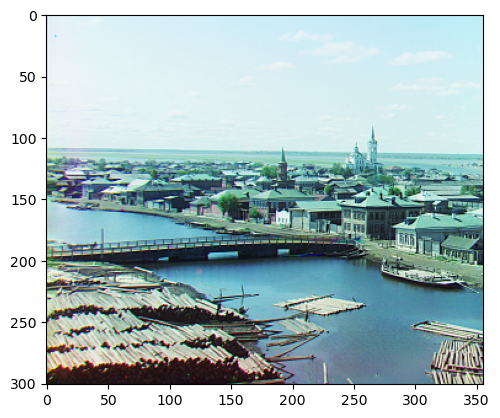

In [72]:
test_colorize_pyramid('../data/tobolsk.jpg', 10)

(-3, 2) (3, 2)


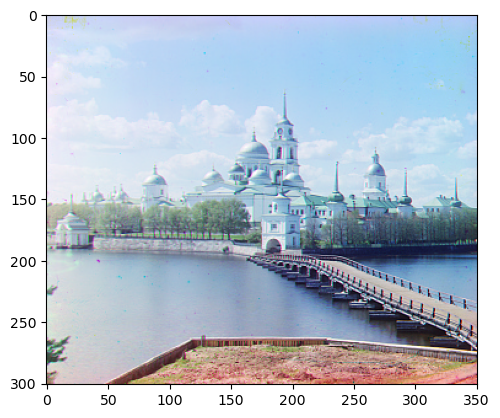

In [73]:
test_colorize_pyramid('../data/monastery.jpg', 10)

(5, 2) (12, 3)


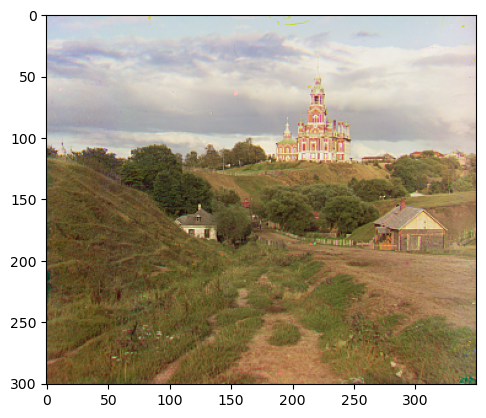

In [109]:

test_colorize_pyramid('../data/cathedral.jpg', 19)

In [111]:
test_colorize_pyramid('../data/church.tif', 10)

ValueError: shapes (96,) and (0,) not aligned: 96 (dim 0) != 0 (dim 0)

(25, 4) (45, -5)


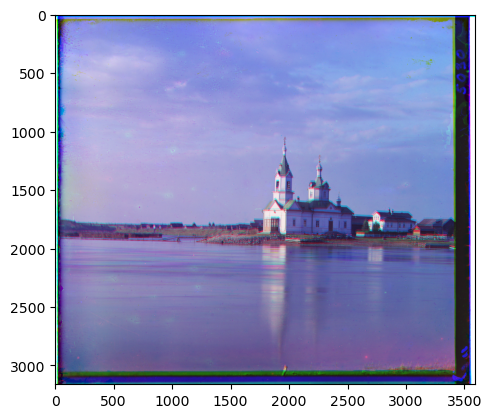

In [98]:
test_colorize_pyramid('../data/church.tif', 60)

(23, -7) (30, -13)


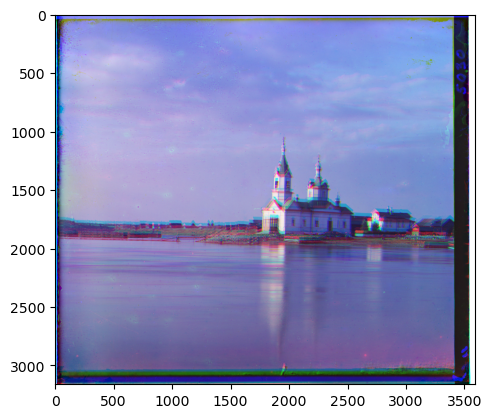

In [62]:
test_colorize_pyramid('../data/church.tif', 30) # one level pyramid test

(5, -8) (50, -12)


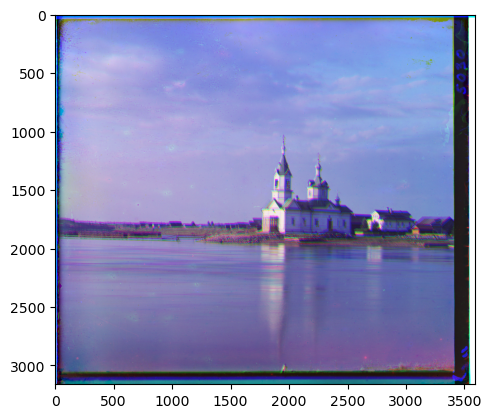

In [64]:
#really big range test (this is gonna take a while)
test_colorize_pyramid('../data/church.tif', 50) # one level pyramid test

(25, 2) (57, -5)


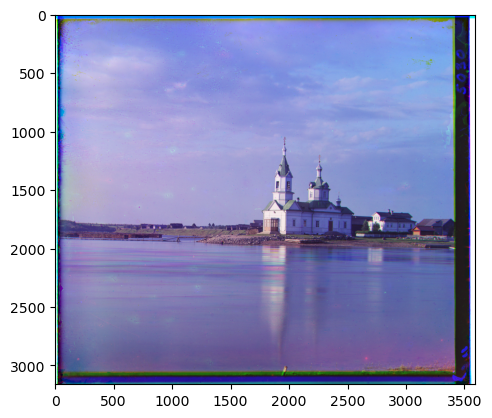

In [65]:
# ok that was a big improvement but we're still maxing out the search range! lets go higher!!
test_colorize_pyramid('../data/church.tif', 100) # one level pyramid test

In [ ]:
test_colorize_pyramid('../data/emir.tif', 30)

In [ ]:
test_colorize_pyramid('../data/onion_church.tif', 30)